In [1]:
from datasets import load_dataset

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset=load_dataset("DFKI-SLT/conll04")

In [3]:
entity_labels=set()
for i in range(len(dataset['test'])):
    for j in dataset['test'][i]['entities']:
        entity_labels.add(j['type'])

In [4]:
entity_labels

{'Loc', 'Org', 'Other', 'Peop'}

In [5]:
test=dataset['test']

In [6]:
test[0]['entities']

[{'end': 7, 'start': 5, 'type': 'Org'},
 {'end': 9, 'start': 8, 'type': 'Other'},
 {'end': 11, 'start': 10, 'type': 'Loc'},
 {'end': 18, 'start': 17, 'type': 'Other'}]

In [7]:
entity_labels_count_true={}
for i in range(len(dataset['test'])):
    for j in dataset['test'][i]['entities']:
        if j['type'] not in entity_labels_count_true:
            entity_labels_count_true[j['type']]=0
        entity_labels_count_true[j['type']]+=1

In [8]:
ner=[]
for i in range(len(test)):
    temp=[]
    for j in test[i]['entities']:
        text=' '.join(test[i]['tokens'][j['start']:j['end']])
        temp.append([j['start'], j['end']-1,j['type'],text])
    ner.append(temp)

In [9]:
entity_other={}
for i in range(len(ner)):
    for j in ner[i]:
        if j[2]=='Other':
            if j[3] not in entity_other:
                entity_other[j[3]]=0
            entity_other[j[3]]+=1
        

In [10]:
entity_other

{'Arab': 1,
 'Palestinians': 1,
 'American': 2,
 'Dec. 13 ,': 1,
 'Dec. 16 ,': 1,
 '1973': 1,
 '1974': 1,
 'Watergate': 2,
 'Cuban missile crisis': 1,
 'Armenian': 1,
 'British': 1,
 '100 million years': 1,
 '69 mph': 1,
 '57 mph': 1,
 '2 a.m.': 1,
 '9 degrees': 1,
 '85 degrees': 1,
 'Jan. 3': 1,
 '$3.2 billion': 1,
 '$3.6 billion': 1,
 '$1 , 600 ,': 1,
 'April 4 , 1968': 1,
 '2 million': 1,
 '8 million': 1,
 '1980': 1,
 'Poles': 1,
 '14 , 800 feet': 1,
 '$5 million': 1,
 '1985': 1,
 'Mexican': 1,
 '50 mph': 1,
 '10 percent': 2,
 '$60.6 million': 1,
 '3 p.m.': 1,
 'July 31 , 1989': 1,
 '1942.': 1,
 '1942': 1,
 '15 miles': 1,
 '6 million acres': 1,
 '1988': 1,
 '15 percent': 1,
 '$100 million': 1,
 '2 a.m. EDT': 1,
 '3 a.m. EDT': 1,
 '60 , 000 acres': 1,
 '40 million': 1,
 'March 16 , 1985.': 1,
 '2 p.m. EDT': 1,
 '7 -': 1,
 '84 percent': 1,
 '11 , 700 acres': 1,
 '28 percent': 1,
 'March 1994': 1,
 '1924 GMT': 1,
 '21 Mar 94': 1,
 '100 kilometres': 1,
 '6 Feb 94': 1,
 '1646 GMT': 1,
 '

In [11]:
entity_labels_count_true

{'Org': 198, 'Other': 133, 'Loc': 427, 'Peop': 321}

In [15]:
from gliner import GLiNER

import os
import torch
from tqdm import tqdm

# text="The branding of the CSAT survey email has been made generic to ensure that end customers do not associate it with DevRev."
model=GLiNER.from_pretrained("urchade/gliner_large-v2.1")
# Force usage of GPU 1
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = model.to(device)

predicted_ner=[]

labels=['Location', 'Organisation', 'People', 'Date', 'Person', 'Other']
# labels=all_entities
results=[]
entity_labels_count_predicted={}
for i in tqdm(range(len(test))):
    text=test[i]['tokens']
    text=' '.join(text)
    entities=model.predict_entities(text,labels=labels,threshold=0.5,multi_label=True)
    real=set()
    import re
    temp=[]
    # dtokens = re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", text)

    for entity in entities:
        # ent_text=re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", entity['text'])
        if entity['label'] not in entity_labels_count_predicted:
            entity_labels_count_predicted[entity['label']]=0
        entity_labels_count_predicted[entity['label']]+=1
        if entity['text'] not in real:
            temp.append([entity['start'], entity['end']-1, entity['label'], entity['text']])

        real.add(entity['text'])
    predicted_ner.append(temp)
    real=list(real)
    results.append(real)
    

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 45221.61it/s]
/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 288/288 [00:19<00:00, 14.65it/s]


In [80]:
pred_ner=[]
for i in range(len(test)):
    text=test[i]['tokens']
    temp=[]
    for j in predicted_ner[i]:
        token=j[3].split(' ')
        try:
            start=text.index(token[0])
            end=text.index(token[-1],start)
            ent=' '.join(text[start:end+1])
            temp.append([start, end, j[2], ent])
        except:
            pass
    pred_ner.append(temp)

In [81]:
predicted_ner[0]

[[22, 37, 'Organisation', 'Hakawati Theatre'],
 [42, 60, 'Location', 'Arab east Jerusalem'],
 [91, 102, 'People', 'Palestinians']]

In [82]:
pred_ner[0]

[[5, 6, 'Organisation', 'Hakawati Theatre'],
 [8, 10, 'Location', 'Arab east Jerusalem'],
 [17, 17, 'People', 'Palestinians']]

In [83]:
ner[0]

[[5, 6, 'Org', 'Hakawati Theatre'],
 [8, 8, 'Other', 'Arab'],
 [10, 10, 'Loc', 'Jerusalem'],
 [17, 17, 'Other', 'Palestinians']]

In [84]:
entity_labels_count_predicted

{'Organisation': 268,
 'Location': 402,
 'People': 44,
 'Person': 318,
 'Date': 125,
 'Other': 12}

In [85]:
entity_labels_count_true

{'Org': 198, 'Other': 133, 'Loc': 427, 'Peop': 321}

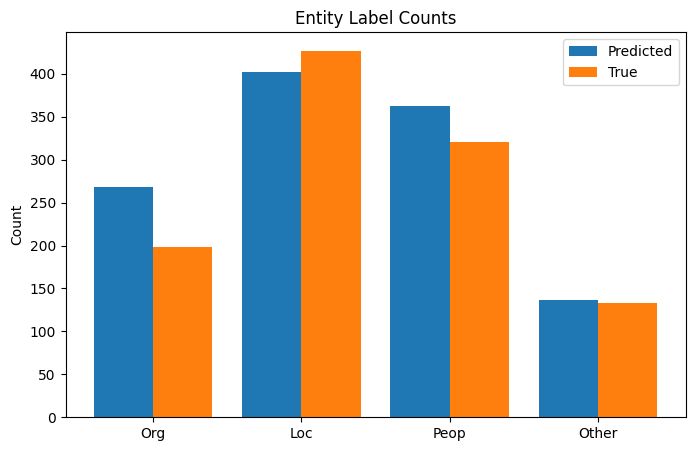

In [86]:
import matplotlib.pyplot as plt

# Merge and map predicted labels
entity_labels_count_predicted_mapped = {
    'Org': entity_labels_count_predicted.get('Organisation', 0),
    'Loc': entity_labels_count_predicted.get('Location', 0),
    'Peop': entity_labels_count_predicted.get('People', 0) + entity_labels_count_predicted.get('Person', 0),
    'Other': entity_labels_count_predicted.get('Other', 0) + entity_labels_count_predicted.get('Date', 0)
}

# True labels are already in the correct format
entity_labels_count_true_mapped = entity_labels_count_true

labels = ['Org', 'Loc', 'Peop', 'Other']
counts_pred = [entity_labels_count_predicted_mapped.get(l, 0) for l in labels]
counts_true = [entity_labels_count_true_mapped.get(l, 0) for l in labels]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, counts_pred, width=0.4, label='Predicted', align='center')
plt.bar([i + 0.4 for i in x], counts_true, width=0.4, label='True', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Entity Label Counts')
plt.legend()
plt.show()

In [87]:
results[6]

['Soviet ships', 'Nikita Khrushchev', 'President Kennedy']

In [88]:
true=[]
for i in range(len(test)):
    temp=[]
    for j in test[i]['entities']:
        text=' '.join(test[i]['tokens'][j['start']:j['end']])
        temp.append(text)
    true.append(temp)

In [89]:
results[34]

['U.S.', 'Bush administration', 'President Nixon']

In [90]:
true[34]

['Watergate', 'U.S.', 'Bush']

In [91]:
their=0
ours=0
common=0
for i in range(len(results)):
    their+=len(set(true[i]))
    ours+=len(set(results[i]))
    common+=len(set(true[i]).intersection(set(results[i])))

In [92]:
their,ours,common

(1059, 1141, 773)

In [93]:
recall_avg=[]
precision_avg=[]
common2=0
for i in range(len(results)):
    true_set=set(true[i])
    pred_set=set(results[i])
    
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                
                if m == n or m[:-2]==n:
                    count+= 1
        recall = count / len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(pred_set) > 0 else 0
        common2 += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [94]:
common2

777

In [95]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.7556988536155198, 0.7059909611992947)

In [96]:
recall_avg

[0.5,
 1.0,
 0.6666666666666666,
 0.75,
 1.0,
 0.8571428571428571,
 0.25,
 1.0,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7,
 0.5,
 0.6666666666666666,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.6,
 0.0,
 1.0,
 1.0,
 0.8,
 1.0,
 1.0,
 1.0,
 0.75,
 0.4,
 0.3333333333333333,
 0.5714285714285714,
 1.0,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.5,
 0.6666666666666666,
 1.0,
 0.5,
 0.75,
 0.8333333333333334,
 0.25,
 1.0,
 0.75,
 1.0,
 1.0,
 0.6666666666666666,
 1.0,
 0.5,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.75,
 0.5,
 1.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.4,
 0.6666666666666666,
 0.5,
 0.6666666666666666,
 0.75,
 1.0,
 0.5,
 0.3333333333333333,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 0.16666666666666666,
 0.6666666666666666,
 0.8,
 0.4,
 0.5,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.8333333333333334,
 0.75,
 1.0,
 1.0,
 1.0,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 1.0,
 0.333333333

In [97]:
ner[2]

[[0, 0, 'Peop', 'Reagan'],
 [26, 26, 'Other', 'American'],
 [32, 32, 'Loc', 'America'],
 [52, 52, 'Other', 'American']]

In [98]:
ner[0]

[[5, 6, 'Org', 'Hakawati Theatre'],
 [8, 8, 'Other', 'Arab'],
 [10, 10, 'Loc', 'Jerusalem'],
 [17, 17, 'Other', 'Palestinians']]

In [99]:
from pair2rel import Pair2Rel

rel_model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel", cache_dir="/tmp/hf_cache",force_download=True)

rel_model = rel_model.to(device)

labels=['Work_For', 'Live_In', 'OrgBased_In', 'Located_In','Kill']

relations_all=[]
head_asset={'Peop':'Org','Peop':'Loc','Org':'Loc','Loc':'Loc','Peop':'Peop'}
for i in tqdm(range(len(test))):
    
    relations = rel_model.predict_relations(test[i]['tokens'], labels, threshold=0.1, ner=ner[i], top_k=1)
    d={}
    for item in ner[i]:
        d[item[3]]=item[2]

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        if head!=tail and (d[head]=='Peop' and d[tail]=='Peop') or (d[head]=='Peop' and d[tail]=='Org') or (d[head]=='Peop' and d[tail]=='Loc') or (d[head]=='Org' and d[tail]=='Loc') or (d[head]=='Loc' and d[tail]=='Loc'):
            temp.append([head,tail,item['label']])
    relations_all.append(temp)
        
print("Success! ✅")

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 288/288 [00:27<00:00, 10.52it/s]

Success! ✅


In [100]:
relations_true=[]
for i in range(len(test)):
    temp=[]
    for j in test[i]['relations']:
        head=ner[i][j['head']][3]
        tail=ner[i][j['tail']][3]
        temp.append([head, tail, j['type']])
    relations_true.append(temp)

In [101]:
ner[16]

[[2, 2, 'Loc', 'Moscow'],
 [4, 5, 'Org', 'Bolshoi Ballet'],
 [7, 7, 'Loc', 'Moscow'],
 [9, 9, 'Loc', 'Leningrad'],
 [11, 12, 'Org', 'Kirov Ballet'],
 [20, 20, 'Other', 'Armenian'],
 [23, 23, 'Loc', 'Yerevan'],
 [26, 26, 'Loc', 'U.S.'],
 [28, 29, 'Peop', 'June Anderson'],
 [31, 32, 'Peop', 'Carol Vaness'],
 [34, 34, 'Other', 'British']]

In [102]:
test[16]['relations']

[{'head': 1, 'tail': 0, 'type': 'OrgBased_In'},
 {'head': 1, 'tail': 2, 'type': 'OrgBased_In'},
 {'head': 4, 'tail': 3, 'type': 'OrgBased_In'},
 {'head': 8, 'tail': 7, 'type': 'Live_In'},
 {'head': 9, 'tail': 7, 'type': 'Live_In'}]

In [103]:
' '.join(test[7]['tokens'])

"Anastas Mikoyan , then Soviet first deputy premier , was the catalyst for the reversal of Khrushchev 's order , according to the authors ."

In [104]:
relations_true[7]

[['Anastas Mikoyan', 'Soviet', 'Live_In'], ['Khrushchev', 'Soviet', 'Live_In']]

In [105]:
relations_all[7]

[['Khrushchev', 'Soviet', 'Work_For'],
 ['Anastas Mikoyan', 'Soviet', 'Work_For']]

In [106]:
recall_avg=[]
precision_avg=[]
common=0
ours=0
relations_all_filtered=[]
for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    temp=[]
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
            temp.append([item[0],item[1],item[2]])
    relations_all_filtered.append(temp)
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m[0]==n[0] and m[1]==n[1] and (m[2]==n[2] or (m[2]=='OrgBased_In' and n[2]=='Located_In')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(d) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [107]:
relations_labels_predicted_count={}
relations_labels_true_count={}
for i in range(len(relations_all)):
    for j in relations_all_filtered[i]:
        if j[2] not in relations_labels_predicted_count:
            relations_labels_predicted_count[j[2]]=0
        relations_labels_predicted_count[j[2]]+=1
    for j in relations_true[i]:
        if j[2] not in relations_labels_true_count:
            relations_labels_true_count[j[2]]=0
        relations_labels_true_count[j[2]]+=1
        

In [108]:
relations_labels_true_count

{'OrgBased_In': 105,
 'Located_In': 94,
 'Live_In': 100,
 'Work_For': 76,
 'Kill': 47}

In [109]:
relations_labels_predicted_count

{'Located_In': 419,
 'Live_In': 226,
 'Work_For': 201,
 'Kill': 73,
 'OrgBased_In': 1}

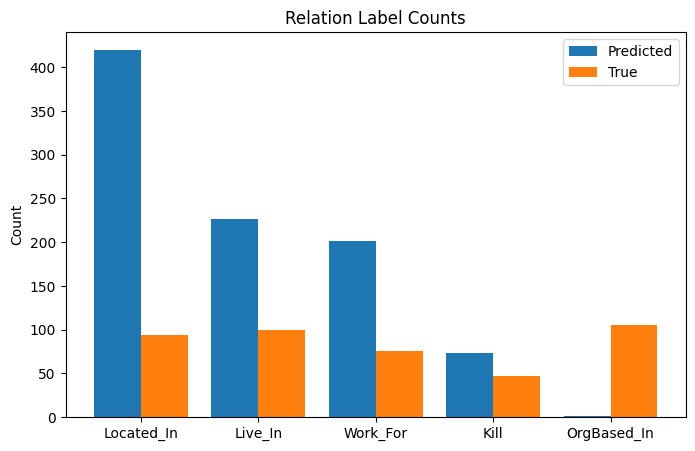

In [110]:
import matplotlib.pyplot as plt



labels = ['Located_In', 'Live_In', 'Work_For', 'Kill', 'OrgBased_In']
counts_pred = [relations_labels_predicted_count.get(l, 0) for l in labels]
counts_true = [relations_labels_true_count.get(l, 0) for l in labels]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, counts_pred, width=0.4, label='Predicted', align='center')
plt.bar([i + 0.4 for i in x], counts_true, width=0.4, label='True', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Relation Label Counts')
plt.legend()
plt.show()

In [111]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.8250578703703704, 0.5565866005816988)

In [112]:
their=0
for i in range(len(relations_all)):
    their+=len(relations_true[i])
    

In [113]:
their,ours,common

(422, 920, 368)

In [115]:
from pair2rel import Pair2Rel

rel_model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel", cache_dir="/tmp/hf_cache",force_download=True)

rel_model = rel_model.to(device)

labels=['Work_For', 'Live_In', 'OrgBased_In', 'Located_In','Kill']

relations_all=[]
head_asset={'Peop':'Org','Peop':'Loc','Org':'Loc','Loc':'Loc','Peop':'Peop'}
for i in tqdm(range(len(test))):
    
    relations = rel_model.predict_relations(test[i]['tokens'], labels, threshold=0.1, ner=pred_ner[i], top_k=1)
    d={}
    for item in ner[i]:
        d[item[3]]=item[2]

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        try:
            if head!=tail and (d[head]=='Peop' and d[tail]=='Peop') or (d[head]=='Peop' and d[tail]=='Org') or (d[head]=='Peop' and d[tail]=='Loc') or (d[head]=='Org' and d[tail]=='Loc') or (d[head]=='Loc' and d[tail]=='Loc'):
                temp.append([head,tail,item['label']])
        except:
            pass
    relations_all.append(temp)
        
print("Success! ✅")

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 288/288 [00:29<00:00,  9.86it/s]

Success! ✅


In [116]:
relations_true=[]
for i in range(len(test)):
    temp=[]
    for j in test[i]['relations']:
        head=ner[i][j['head']][3]
        tail=ner[i][j['tail']][3]
        temp.append([head, tail, j['type']])
    relations_true.append(temp)

In [120]:
recall_avg=[]
precision_avg=[]
common=0
ours=0
relations_all_filtered=[]
for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    temp=[]
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
            temp.append([item[0],item[1],item[2]])
    relations_all_filtered.append(temp)
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if (m[0] in n[0] or n[0] in m[0]) and (m[1] in n[1] or n[1] in m[1]) and (m[2]==n[2] or (m[2]=='OrgBased_In' and n[2]=='Located_In')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(d) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [121]:
relations_labels_predicted_count={}
relations_labels_true_count={}
for i in range(len(relations_all)):
    for j in relations_all_filtered[i]:
        if j[2] not in relations_labels_predicted_count:
            relations_labels_predicted_count[j[2]]=0
        relations_labels_predicted_count[j[2]]+=1
    for j in relations_true[i]:
        if j[2] not in relations_labels_true_count:
            relations_labels_true_count[j[2]]=0
        relations_labels_true_count[j[2]]+=1
        

In [122]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.5293680856180857, 0.4248319003527335)